<a href="https://colab.research.google.com/github/QidiLiu/ML_notebook/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 手写数字图片的分类 - Classification

In [1]:
# 引入手写图像数据库
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

数据库结构：70000个图像和对应的70000个标签

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


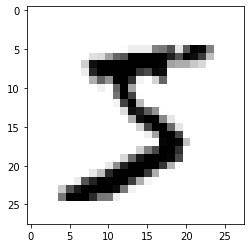

5


In [3]:
# 随便一看
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.show()

print(y[0])

In [0]:
import numpy as np

# 把标签格式由String转为Integer
y = y.astype(np.uint8)

# MNIST中前六万个是train set，后一万个是test set.所以可以直接分，不用考虑怎么分
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
# 搞一个"是否"分类器（此处判断目标：是不是5）
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5) # 把标签转为布尔值

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
# 随便预测一下
sgd_clf.predict([some_digit])

array([ True])

这是最入门的一种分类器，判断图片数字是否为5。上一行的输出表明预测值与实际值相同。

但这只是个入门，在这次训练和预测过程中，数据集本身就被调节到适合训练的样子，预测也很随便，一切设定都是为了读者能更简单的把握“分类器”的核心概念。

在性能评估方面，分类器比回归器更棘手一些。

In [7]:
# Measuring Accuracy Using Cross-Validation
# 这段代码其实是Scikit-learn的cross_val_score()的核心算法，只供理解，没必要这么麻烦
from sklearn.model_selection import StratifiedKFold
from sklearn import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42) # n_splits:分成3份，其中两份做样本，剩下一份做测试：random_state:洗牌的种子

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf) # 克隆已训练好的二元分类器
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred == y_test_folds)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


此处Cross-Validation的算法逻辑是先把数据集分为样本和标签的训练层和测试层，再用训练层训练模型，最后用测试层计算准确度。为啥不用之前分好的train set和test set呢，因为**要把test set留到最后用**。

来自[sklearn包中StratifiedKFold和KFold生成交叉验证数据集的区别](https://blog.csdn.net/MsSpark/article/details/84455402)：
- KFold交叉采样：将训练/测试数据集划分n_splits个互斥子集，每次只用其中一个子集当做测试集，剩下的（n_splits-1）作为训练集，进行n_splits次实验并得到n_splits个结果。
- StratifiedKFold分层采样，用于交叉验证：与KFold最大的差异在于，StratifiedKFold方法是根据标签中不同类别占比来进行拆分数据的。
- 两种采样器对象的各参数：
  - n_splits：表示将数据划分几等份
  - shuffle：在每次划分时，是否进行洗牌
    - 若为False，其效果相当于random_state为整数(含零)，每次划分的结果相同
    - 若为True，每次划分的结果不一样，表示经过洗牌，随机取样的
  - random_state：随机种子数，当设定值(一般为0)后可方便调参，因为每次生成的数据集相同

In [8]:
# sklearn库内集成的Cross-Validation算法
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

预测准确率不适合作为分类器的评价标准。如果我们做一个Not-5-classifier，这个分类器不做任何计算不管输入什么都是输出True（也就是说，这个分类器分类全靠蒙），那么在一个5很少的测试集里（比如这个0-9均匀分布的手写数字集），这个分类器的准确率可高达90%，略低于上面用的SGDClassifier（随机梯度下降模型）。

所以要引入**Confusion Matrix（[混淆矩阵](https://zh.wikipedia.org/wiki/%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5)）**。

混淆矩阵的核心是把预测结果的错误部分细分为**误判——False Negative(FN)**和**漏判——False Positive(FP)**。

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # 本方法返回测试层的预测结果集

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])